In [30]:
import pandas as pd

df = pd.read_csv('IMDB-Dataset.csv')

df = df.drop_duplicates()

df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [31]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    
    wl = WordNetLemmatizer()

    soup = BeautifulSoup(text, "html.parser")

    text = soup.get_text()
    text = expand_contractions(text)

    emoji_clean = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)

    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text)
    text = re.sub(r'http\S+', '', text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) 

    return text

df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quanb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quanb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\quanb\AppData\Local\Temp\ipykernel_25616\428249853.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


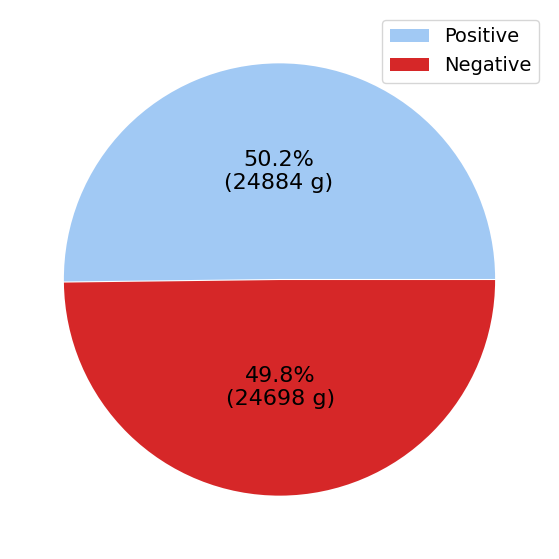

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['Positive', 'Negative']

pie, ax = plt.subplots(figsize=[11,7])
plt.pie(data, autopct=lambda pct: func(pct, data), explode =[0.0025]*2,
        pctdistance=0.5, colors=[sns.color_palette('pastel')[0], 'tab:red'], textprops={'fontsize': 16})

labels = [r'Positive', r'Negative']
plt.legend(labels, loc='best', prop={'size': 14})
plt.savefig('PieChart.png')
plt.show()

In [35]:
# Word length
words_len = df['review'].str.split().map(lambda x: len(x))


df_temp = df.copy()
df_temp['words length'] = words_len

df_temp

,review,sentiment,words length
0,one reviewer mentioned watching oz episode hoo...,positive,162
1,wonderful little production filming technique ...,positive,84
2,thought wonderful way spend time hot summer we...,positive,84
3,basically family little boy jake think zombie ...,negative,64
4,petter matteis love time money visually stunni...,positive,125
...,...,...,...
49995,thought movie right good job creative original...,positive,74
49996,bad plot bad dialogue bad acting idiotic direc...,negative,56
49997,catholic taught parochial elementary school nu...,negative,113
49998,going disagree previous comment side maltin on...,negative,112


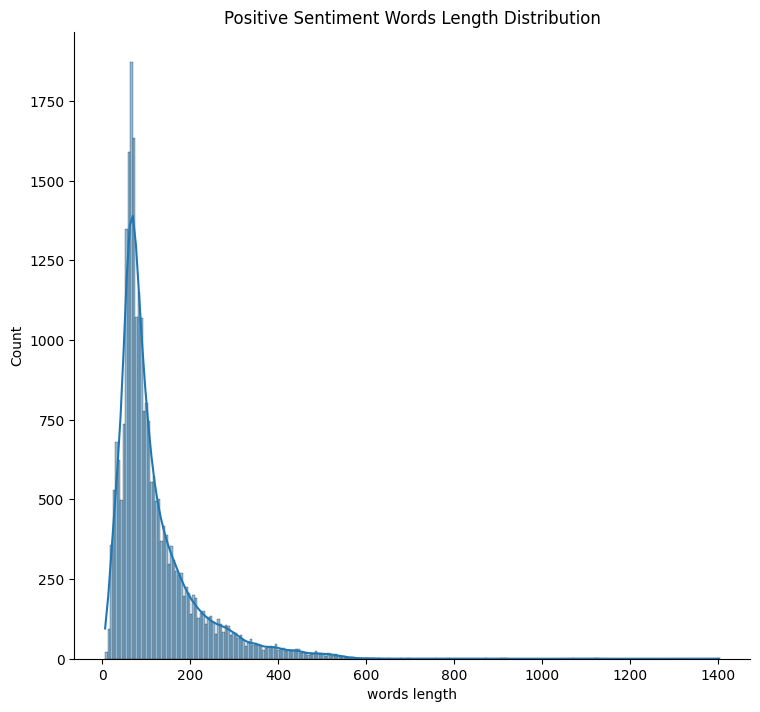

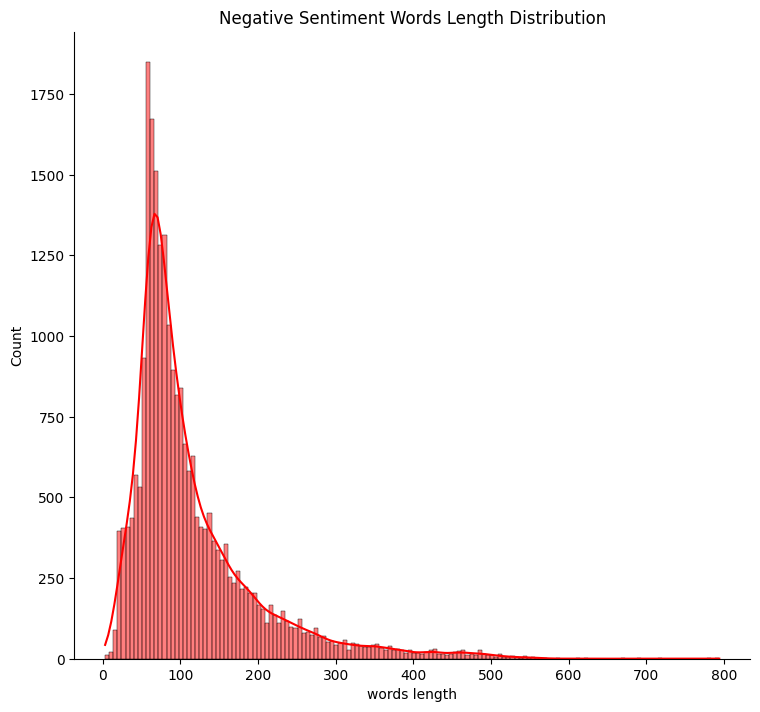

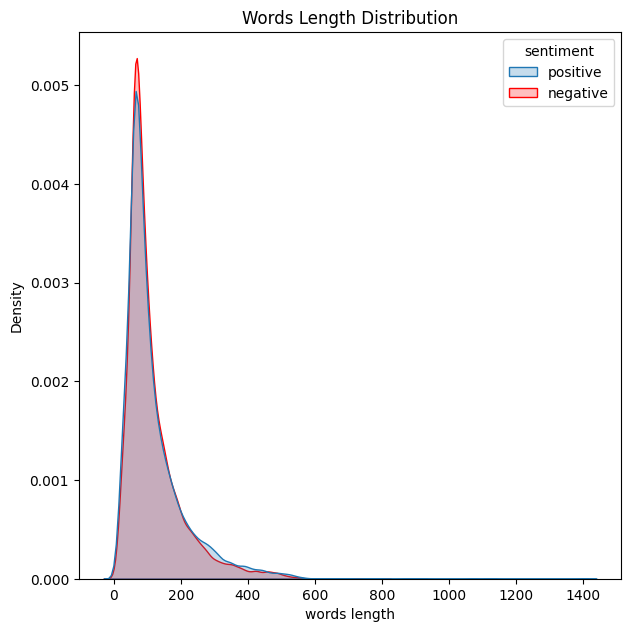

In [36]:

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True , height =7 , aspect =1.1 , 
    legend = False
).set(title = 'Positive Sentiment Words Length Distribution')
plt.show(hist_positive)

hist_negative = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'negative'],
    x = 'words length', hue = 'sentiment', kde = True, height = 7, aspect = 1.1,
    legend = False, palette = ['red']
).set(title = 'Negative Sentiment Words Length Distribution')
plt.show(hist_negative)

plt.figure(figsize=(7, 7.1))
kernel_distribution = sns.kdeplot(
    data = df_temp, x = 'words length', hue = 'sentiment', fill = True,
    palette = [sns.color_palette()[0], 'red']
).set(title = 'Words Length Distribution')
plt.show(kernel_distribution)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

x_data = df['review']

label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_features=100000)
tfidf_vectorizer.fit(X_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(X_train)
x_test_encoded = tfidf_vectorizer.transform(X_test)

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy', random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7136230714933952

In [41]:
rf_classifier = RandomForestClassifier(
    random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8480387213875163

In [43]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifier = AdaBoostClassifier(
    random_state=42)
adaboost_classifier.fit(x_train_encoded, y_train)
y_pred = adaboost_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

c:\Users\quanb\anaconda3\envs\ts\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7911666834728245

In [44]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gradientboost_classifier = GradientBoostingClassifier(
    random_state=42)
gradientboost_classifier.fit(x_train_encoded, y_train)
y_pred = gradientboost_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7946959766058284

In [47]:
# XGBoost
from xgboost import XGBClassifier

xgboost_classifier = XGBClassifier(
    random_state=42)
xgboost_classifier.fit(x_train_encoded, y_train)
y_pred = xgboost_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8461228194010285